# GETTING THE DATA

In [18]:
import matplotlib;
import matplotlib.pyplot as plt;
from sklearn.datasets import fetch_openml;
mnist = fetch_openml("mnist_784");
#mnist = datase
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel50',
  'pixel51',
  '

## Structure
Datasets loaded by scikit-learn will have the following structure:
- *DESCR* key describing the dataset
- *data* key containing an array with one row per instance and one column per feature
- *target* key containing an array with the labels

In [92]:
type(mnist)

sklearn.utils.Bunch

In [15]:
X, y = mnist['data'], mnist['target'];
y = y.astype(int);

In [3]:
X.shape, y.shape

((70000, 784), (70000,))

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

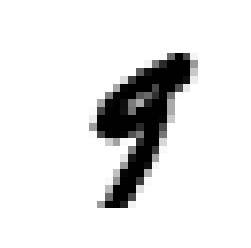

'9'

In [69]:
%matplotlib inline
some_digit = X[36000];
some_digit_img = some_digit.reshape(28,28);
plt.imshow(some_digit_img, cmap = matplotlib.cm.binary, interpolation="nearest");
plt.axis("off");
plt.show();
y[36000]

## Splitting in train/test
The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images).

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learn‐ ing algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.


In [19]:
import numpy as np
X_train_pre, X_test, y_train_pre, y_test = X[:60000], X[60000:], y[:60000], y[60000:];
shuffle_index = np.random.permutation(60000);
X_train, y_train = X_train_pre[shuffle_index], y_train_pre[shuffle_index];
del y_train_pre, X_train_pre

# Training a Binary Classifier
Let's focus on one digit only. 2 classes: 9 and not-9

In [72]:
#target vector:
y_train_5 = (y_train.astype("int")== 5)
y_test_5  = (y_test.astype("int") == 5)
y_train_9 = (y_train.astype("int")== 9)
y_test_9  = (y_test.astype("int") == 9)


## Stochastic Gradient Descent Classifier

In [73]:
from sklearn.linear_model import SGDClassifier
sgd_clf_5 = SGDClassifier(random_state=42, max_iter=100000, tol=0.01);# to reproduce the same result use the same random_state
sgd_clf_9 = SGDClassifier(random_state=42, max_iter=100000, tol=0.01);# to reproduce the same result use the same random_state
sgd_clf_5.fit(X_train, y_train_5);
sgd_clf_9.fit(X_train, y_train_9);

In [74]:
np.where(y_train_5==True)[0][0]

18

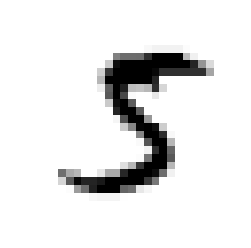

array([ True])

In [75]:
#some_digit was defined before:
t= X_train[np.where(y_train_5==True)[0][0]]
some_digit_img = t.reshape(28,28)
plt.imshow(some_digit_img, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
sgd_clf_5.predict([t]) #32 is a 5

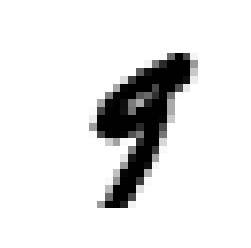

array([False])

In [76]:
#some_digit was defined before:
t = some_digit
some_digit_img = t.reshape(28,28)
plt.imshow(some_digit_img, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
sgd_clf_9.predict([t]) #error

# Implementing cross-validation
StratifiedKfold performs stratified sampling. In this case K=3 for cross-validation

At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [77]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# StratifiedKfold performs stratified sampling
# In this case K=3 for cross-validation
skfolds = StratifiedKFold(n_splits=3, random_state=42);
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf_5);
    X_train_folds = X_train[train_index];
    y_train_folds = y_train_5[train_index];
    X_test_fold   = X_train[test_index];
    y_test_fold   = y_train_5[test_index];
    clone_clf.fit(X_train_folds, y_train_folds);
    y_pred        = clone_clf.predict(X_test_fold);
    n_correct     = sum(y_pred== y_test_fold);
    print(n_correct/len(y_pred))

0.9016
0.958
0.9645


In [78]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf_5, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9016, 0.958 , 0.9645])

This classifier looks great but...

## Fake classifier classifying evrything as non-5

In [79]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass;
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool);

In [80]:
never5 = Never5Classifier();
cross_val_score(never5, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91165, 0.91125, 0.90605])

This fake classifier has over 90% of accuracy: only 10% of the images are 5. Saying always that it is not a 5 you are right about 90% times.

### Accuracy is generally not a good performance measure for classifiers especially when dealing with skewed datasets.

# Confusion matrix
Count the number of times instances of class A are classified as class B.

`cross_val_predict` performs K-fold and returns the predictions instead of the evaluation score.

The rows of confusion metrix represent an actual class while the columns represent a predicted class. The first row consider non-5 images. non-5 imagese are called negative: binarily speaking false means it is non-5.

    true negative    false positive
    false negative   true positive
    
$Precision = \frac{TP}{TP+FP}$

$recall/sensitivity/True Positive Rate(TPR) = \frac{TP}{TP+FN}$.

It is often convenient to combine precision and recall into a single metric called the F1 score

$F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = 2 \frac{precision \times recall}{precision+recall} = \frac{TP}{TP+\frac{FN+FP}{2}}$

The F1 score favors classifiers that have similar precision and recall. This is not always desired: in some cases precision is more valuable and in others, one cares more about recall.

In [81]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf_5, X_train, y_train_5, cv=3);

In [82]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52493,  2086],
       [ 1432,  3989]])

In [83]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.6566255144032922

In [84]:
recall_score(y_train_5, y_train_pred)

0.7358420955543258

Now your 5-detector does not look as shiny as it did when you looked at its accuracy.

In [85]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.6939805149617257

The SGDClassifier uses a threshold =0 so the following code is the same as `predict()`.

In [86]:
y_score = sgd_clf_5.decision_function([X_train[np.where(y_train_5==True)[0][2]]]);
threshold = 0;
y_some_digit_pred = (y_score>threshold);

In [87]:
threshold = 20000;
y_some_digit_pred = (y_score>threshold);
y_some_digit_pred

array([False])

## How to choose a proper threshold?
Use `cross_val_predict` specifying we want it to return decision scores instead of predictions.


In [88]:
y_scores = cross_val_predict(sgd_clf_5, X_train, y_train_5, cv=3, method="decision_function");

`precision_recall_curve` returns:	
- precision : array, `shape = [n_thresholds + 1]`. Precision values such that element `i` is the precision of predictions with `score >= thresholds[i]` and the last element is `1`.
- recall : array, `shape = [n_thresholds + 1]`
Decreasing recall values such that element `i` is the recall of predictions with `score >= thresholds[i]` and the last element is `0`.
- thresholds : array, `shape = [n_thresholds <= len(np.unique(probas_pred))]`.
Increasing thresholds on the decision function used to compute precision and recall.

In [89]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores);

We can plot precision and recall as a function of the threshold


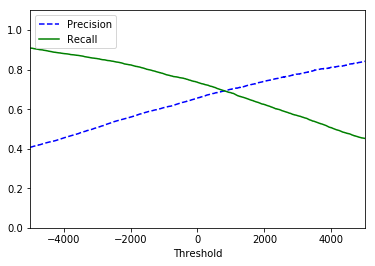

In [90]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, xlims=None): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1.1])
    if xlims:
        plt.xlim(xlims)

    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds,[-5000, 5000]);
plt.show();

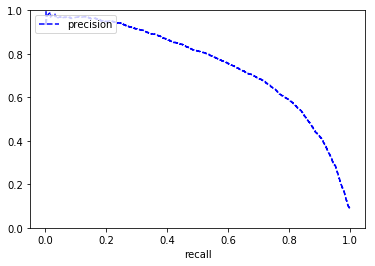

In [91]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions,'b--', label="precision");

    plt.xlabel("recall");
    plt.legend(loc="upper left");
    plt.ylim([0,1 ]);
    
plot_precision_vs_recall(precisions, recalls);
plt.show();

You can see that precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall tradeoff just before that drop—for example, at around 60% recall.

So let’s suppose you decide to aim for 90% precision. You look up the first plot (zooming in a bit) and find that you need to use a threshold of about 5,000. 

In [92]:
y_train_pred_90 = (y_scores>3500)
precision_score(y_train_5, y_train_pred_90)

0.7973194748358862

In [93]:
recall_score(y_train_5, y_train_pred_90)

0.5377236672200701

# ROC curve
The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It plots true positive rate against false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus 1 – specificity.

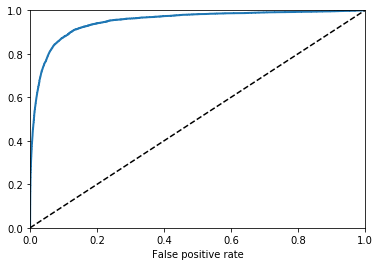

In [94]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores);

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label);
    plt.plot([0,1], [0,1], '--k');
    plt.axis([0,1,0,1]);
    plt.xlabel("False positive rate");
    
plot_roc_curve(fpr, tpr);
plt.show();

One way to compare classifiers is to compare the area under the curve (AUC). A perfect classifier will have ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

The scikit function `roc_auc_score` computes the area.

In [95]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9494850183216765

## ROC vs Precision/Recall
Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top- right corner).

# RandomForest classifier
The `RandomForestClassifier` class does not have a `decision_function()` method. Instead it has a pre `dict_proba()`.
Scikit-Learn classifiers generally have one or the other. The method returns an array containing a row per instance and a col‐ umn per class, each containing the probability that the given instance belongs to the given class 

In [96]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42, n_estimators=10);
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba");

But to plot a ROC curve, you need scores, not probabilities. A simple solution is to
use the positive class’s probability as the score

In [97]:
y_probas_forest

array([[0.9, 0.1],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [0.1, 0.9],
       [1. , 0. ]])

In [98]:
y_scores_forest = y_probas_forest[:,1]#scores = probab. of positive class
y_scores_forest

array([0.1, 0. , 0. , ..., 0. , 0.9, 0. ])

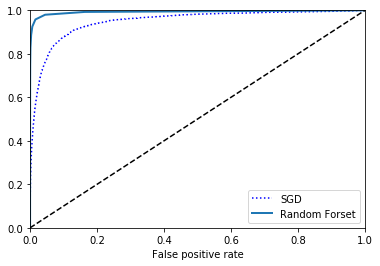

In [99]:

fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest);

plt.plot(fpr, tpr, "b:", label="SGD");
plot_roc_curve(fpr_forest, tpr_forest, "Random Forset");
plt.legend(loc="lower right");
plt.show();

In [100]:
roc_auc_score(y_train_5, y_scores_forest)

0.993014115233231

In [101]:
y_bool_forest = y_scores_forest;
y_bool_forest[y_bool_forest>=0.5]= True;
y_bool_forest[y_bool_forest<0.5]= False

In [102]:
precision_score(y_train_5, y_bool_forest)

0.9652540670817433

In [103]:
recall_score(y_train_5, y_bool_forest)

0.8865522966242391

# Multiclass classification
Some classifiers such as Ranfom Forest or Bayesian classifier are by nature multiclass. Others are just binary but we can train a binary classifier to classify each single class. This is called *one-versus-all (OvA)* strategy.

Another strategy is to train a binary classifier to distinguish between 2 classes. For txample for the digit example train a classifier to distinguish between 0 and 1, another to distinguish between 0s and 2s and so on. This is called *one-versus-one (OvO)* strategy. For $N$ classes you will have to train $\frac{N(N-1)}{2}$ classifiers. The main advan‐ tage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.


Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, however, OvA is preferred.

## OvA SGDClassifier
Scikit-Learn detects when you try to use a binary classification algorithm for a multi‐ class classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO). 

In [104]:
sgd_clf = SGDClassifier(random_state=42, max_iter=100000, tol=0.01);
sgd_clf.fit(X_train, y_train.astype("int"));

In [105]:
a_5_digit = X_train[np.where(y_train.astype("int")==5)[0][0]]
sgd_clf.predict([a_5_digit])

array([5])

In [106]:
a_5_digit_score = sgd_clf.decision_function([a_5_digit])
a_5_digit_score


array([[-14737.36693801,  -9911.18550835,  -8692.60485667,
         -4669.83958941, -21960.2686238 ,   3528.47075814,
        -40089.7103575 , -17074.1577441 ,   2478.23271305,
         -4361.96661168]])

In [111]:
np.argmax(a_5_digit_score)

5

In [108]:
sgd_clf.classes_[np.argmax(a_5_digit_score)]

5

### Forcing a strategy
If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes. Simply create an instance and pass a binary classifier to its constructor.

In [109]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=100000, tol= 0.01))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([X_train[np.where(y_train.astype("int")==5)[0][0]]])

array(['5'], dtype=object)

In [110]:
len(ovo_clf.estimators_)

45

## Random Forest multinomial classifier


In [112]:
forest_clf.fit(X_train, y_train.astype("int"))
forest_clf.predict([X_train[np.where(y_train.astype("int")==5)[0][0]]])

array([5])

In [113]:
forest_clf.predict_proba([X_train[np.where(y_train.astype("int")==5)[0][0]]])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [114]:
cross_val_score(sgd_clf, X_train, y_train.astype("int"), cv=3, scoring="accuracy")

array([0.87787443, 0.86084304, 0.87283092])

## Scaling the inputs will increase accuracy above 90%

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler();
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64));

In [ ]:
cross_val_score(sgd_clf, X_train_scaled, y_train.astype("int"), cv=3, scoring="accuracy");

# Error analysis
Suppose you have found one model that works better than the others. To improve it you might want to see the errors it makes. First of all we can look at the confusion matrix

In [116]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3);
conf_mx = confusion_matrix(y_train, y_train_pred);
conf_mx

array([[5684,    1,   15,   11,   10,   51,   40,    6,  100,    5],
       [   1, 6443,   50,   21,    5,   51,    7,   11,  137,   16],
       [  33,   32, 5328,  106,   72,   27,   72,   44,  231,   13],
       [  35,   25,  128, 5350,    3,  234,   28,   46,  203,   79],
       [  16,   19,   42,   11, 5329,    9,   46,   29,  144,  197],
       [  47,   29,   33,  173,   58, 4598,   93,   24,  284,   82],
       [  31,   17,   51,    3,   45,   95, 5588,    7,   81,    0],
       [  19,   17,   65,   33,   51,   11,    6, 5767,   53,  243],
       [  25,   82,   53,  113,    6,  137,   43,   14, 5303,   75],
       [  30,   26,   32,   79,  129,   33,    1,  175,  167, 5277]])

### The matrix is difficult to visualize: let's look at an image

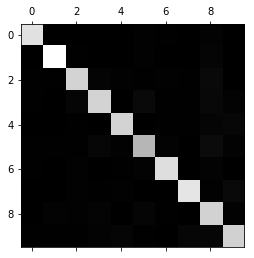

In [117]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

### This looks quite good with elements mainly on the diagonal
To have a better insight, let's look at the errors plot. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors and then we fill the diagonals with $0$.

In [118]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
#row_sums
norm_conf_mx = conf_mx/row_sums

### Comments on errors
The columns for classes 8 and 9 are quite bright, which tells you that many images get misclassified as 8s or 9s.  Similarly, the rows for classes 8 and 9 are also quite bright, telling you that 8s and 9s are often confused with other digits. Errors are not symmetrical. Let's discard the elements classified correctly and focus on the error

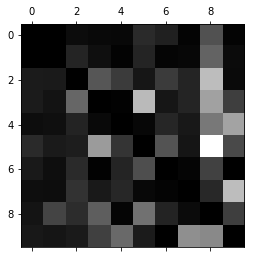

In [119]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [120]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28;
    images_per_row = min(len(instances), images_per_row);
    images = [instance.reshape(size,size) for instance in instances];
    n_rows = (len(instances) - 1) // images_per_row + 1 #// = flooring, + 1 because of the minimum, -1 in case it is 
    # multiple of images_per_rows
    row_images = []
    n_empty = n_rows * images_per_row - len(instances);
    images.append(np.zeros((size, size * n_empty)))
    # It is concatenating the images one next to the other
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row];
        row_images.append(np.concatenate(rimages, axis=1)); # Concatenate images in the same row to get a single image
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

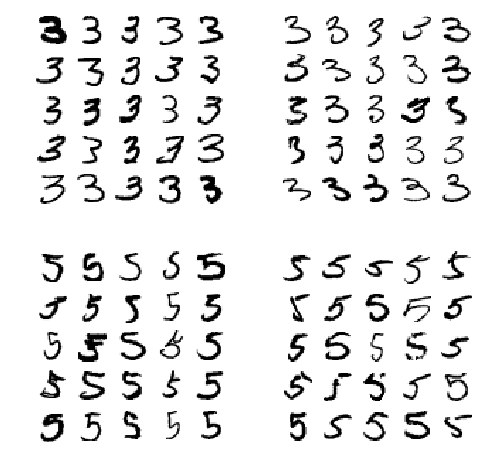

In [121]:
cl_a, cl_b = 3, 5;
X_aa = X_train[(y_train.astype("int")==cl_a) & (y_train_pred.astype("int") == cl_a)];
X_ab = X_train[(y_train.astype("int")==cl_a) & (y_train_pred.astype("int") == cl_b)];
X_ba = X_train[(y_train.astype("int")==cl_b) & (y_train_pred.astype("int") == cl_a)];
X_bb = X_train[(y_train.astype("int")==cl_b) & (y_train_pred.astype("int") == cl_b)];

plt.figure(figsize=(8,8));
plt.subplot(221);plot_digits(X_aa[:25], images_per_row=5);
plt.subplot(222);plot_digits(X_ab[:25], images_per_row=5);
plt.subplot(223);plot_digits(X_ba[:25], images_per_row=5);
plt.subplot(224);plot_digits(X_bb[:25], images_per_row=5);
plt.show();

Some of the digits that the classifier gets wrong. However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did. The reason is that we used a simple *SGDClassifier*, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since $3$s and $5$s differ only by a few pixels, this model will easily confuse them.

The main difference between $3$s and $5$s is the position of the small line that joins the top line to the bottom arc. If you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a $5$, and vice versa. In other words, **this classifier is quite sensitive to image shifting and rotation**. So one way to reduce the $3-5$ confusion would be to preprocess the images to ensure that they are well centered and not too rotated. This will probably help reduce other errors as well.

# Multilabel classification
Not all classifiers support multilabel classification, KNN does.

In [122]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train.astype(int) >=7);
y_train_odd   = (y_train.astype(int)%2==1);
y_multilabel  = np.c_[y_train_large, y_train_odd];
y_multilabel.shape

(60000, 2)

In [126]:
knn_clf = KNeighborsClassifier(n_jobs=-1);

In [123]:
knn_clf.fit(X_train, y_multilabel);

In [124]:
some_digit = X_train[np.where(y_train_5==True)[0][0]];
knn_clf.predict([some_digit])

array([[False,  True]])

## Evaluation of multinomial classifier
There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. For example, one approach is to measure the $F_1$ score for each individual label then simply compute the average score. This assumes that all labels are equally important, which may not be the case. In par‐ ticular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice.

### cross_val_predict on knn_clf takes too much time. We'll use a faster knn_clf altough it will return some warnings.

In [127]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3);

In [128]:
f1_score(y_train, y_train_knn_pred, average='macro')

0.9681111631478091

### Solution: give each label a weight equal to its support (i.e., the number of instances with that target label)

# Multioutput multilabel classification
It is a generalization of the multilabel classification. Each label can be multiclass (i.e., it can have more than two possible values).

Let's add noise to the MNIST images.

In [129]:
import numpy.random as rnd
noise_train = rnd.randint(0, 100, (len(X_train),28*28));
noise_test  = rnd.randint(0, 100, (len(X_test),28*28));
X_train_mod = X_train + noise_train;
X_test_mod  = X_test  + noise_test;
y_train_mod = X_train;
y_test_mod  = X_test; 

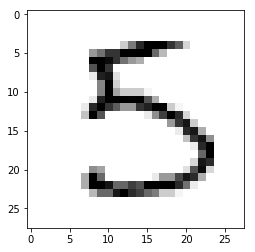

In [130]:
img= plt.imshow(X_test[np.where(y_test=='5')[0][1]].reshape(28,28), cmap=plt.matplotlib.cm.binary);

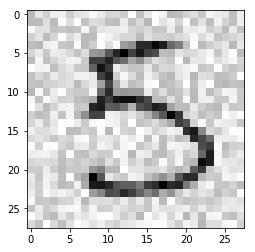

In [131]:
img= plt.imshow(X_test_mod[np.where(y_test=='5')[0][1]].reshape(28,28), cmap=plt.matplotlib.cm.binary);

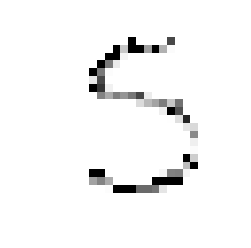

In [132]:
knn_clf.fit(X_train_mod, y_train_mod);
clean_digit = knn_clf.predict([X_test_mod[np.where(y_test=='5')[0][1]]]);
plot_digits(clean_digit);

# Exercises

#### 1) Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the `weights`and `n_neighbors` hyperparameters).

In [4]:
X_train.shape

(60000, 784)

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
param_grid = {"weights": ["uniform", "distance"],"n_neighbors":[3,5,10], };#5,10,15, 20, 25, 30, 40,50]
knn_clf_rs = KNeighborsClassifier(n_jobs=-1);
random_search = RandomizedSearchCV(knn_clf_rs, param_grid, cv=3, 
                                   scoring="neg_mean_squared_error",
                                   verbose = 5, n_jobs=-1);


### It is taking too much time on the training set, let's reduce train size at least to explore

In [9]:
X_short, y_short = X_train[:10000], y_train[:10000]
random_search.fit(X_short, y_short);

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/fra/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:  2.5min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:  5.4min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  5.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  6.0min finished


In [10]:
random_search.best_params_

{'weights': 'distance', 'n_neighbors': 3}

In [18]:
param_grid2

{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5, 6, 7, 8]}

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
X_short, y_short = X_train_scaled[:10000], y_train.astype(int)[:10000];
param_grid2 = {"weights": ["uniform", "distance"],"n_neighbors":[3,4,5,6,7,8], };#5,10,15, 20, 25, 30, 40,50]
knn_clf_rs2 = KNeighborsClassifier(n_jobs=-1);

random_search2 = RandomizedSearchCV(knn_clf_rs2, param_grid2, cv=5, 
                                   scoring="neg_mean_squared_error",
                                   verbose = 5);

In [22]:
random_search2.fit(X_short, y_short);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] weights=distance, n_neighbors=8 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  weights=distance, n_neighbors=8, score=-1.4313529705441836, total=   4.8s
[CV] weights=distance, n_neighbors=8 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.0s remaining:    0.0s


[CV]  weights=distance, n_neighbors=8, score=-1.422077922077922, total=   4.2s
[CV] weights=distance, n_neighbors=8 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.9s remaining:    0.0s


[CV]  weights=distance, n_neighbors=8, score=-1.669665167416292, total=   4.5s
[CV] weights=distance, n_neighbors=8 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   58.2s remaining:    0.0s


[CV]  weights=distance, n_neighbors=8, score=-1.598098098098098, total=   4.6s
[CV] weights=distance, n_neighbors=8 .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[CV]  weights=distance, n_neighbors=8, score=-1.4208416833667334, total=   4.6s
[CV] weights=distance, n_neighbors=5 .................................
[CV]  weights=distance, n_neighbors=5, score=-1.4663005491762358, total=   4.4s
[CV] weights=distance, n_neighbors=5 .................................
[CV]  weights=distance, n_neighbors=5, score=-1.2907092907092907, total=   4.3s
[CV] weights=distance, n_neighbors=5 .................................
[CV]  weights=distance, n_neighbors=5, score=-1.537231384307846, total=   4.5s
[CV] weights=distance, n_neighbors=5 .................................
[CV]  weights=distance, n_neighbors=5, score=-1.5295295295295295, total=   4.4s
[CV] weights=distance, n_neighbors=5 .................................
[CV]  weights=distance, n_neighbors=5, score=-1.4443887775551103, total=   4.8s
[CV] weights=distance, n_neighbors=3 .................................
[CV]  weights=distance, n_neighbors=3, score=-1.5007488766849726, total=   4.4s
[CV] weights=di

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 18.0min finished


In [28]:
random_search2.best_params_

{'weights': 'distance', 'n_neighbors': 4}

In [29]:
random_search2.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [30]:
random_search2.best_score_

-1.3882

In [31]:
len(random_search2.cv_results_["mean_test_score"])

10

In [32]:
cvres = random_search2.cv_results_
for mean, p in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean), p)

1.2281693694275233 {'weights': 'distance', 'n_neighbors': 8}
1.2056533498481228 {'weights': 'distance', 'n_neighbors': 5}
1.1938174064738711 {'weights': 'distance', 'n_neighbors': 3}
1.2239281024635393 {'weights': 'distance', 'n_neighbors': 7}
1.2384667940643383 {'weights': 'uniform', 'n_neighbors': 4}
1.2624183141890806 {'weights': 'uniform', 'n_neighbors': 8}
1.1916375287812984 {'weights': 'distance', 'n_neighbors': 6}
1.1782189949241186 {'weights': 'distance', 'n_neighbors': 4}
1.2366486970841801 {'weights': 'uniform', 'n_neighbors': 5}
1.2444275792507975 {'weights': 'uniform', 'n_neighbors': 6}


#### distance metric seems to be always better
Let's try to use more data

In [33]:
X_short3, y_short3 = X_train_scaled[:30000], y_train.astype(int)[:30000];
param_grid3 = {"weights": ["distance"],"n_neighbors":[3,4,5,6,7,8], };#5,10,15, 20, 25, 30, 40,50]
knn_clf_rs3 = KNeighborsClassifier(n_jobs=-1);

random_search3 = RandomizedSearchCV(knn_clf_rs3, param_grid3, cv=5, 
                                   scoring="neg_mean_squared_error",
                                   verbose = 5);
random_search3.fit(X_short3, y_short3)

/Users/fra/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] weights=distance, n_neighbors=3 .................................
[CV]  weights=distance, n_neighbors=3, score=-1.0697868087941373, total=  33.9s
[CV] weights=distance, n_neighbors=3 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV]  weights=distance, n_neighbors=3, score=-1.0123312781203133, total=  35.9s
[CV] weights=distance, n_neighbors=3 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.6min remaining:    0.0s


[CV]  weights=distance, n_neighbors=3, score=-1.0213333333333334, total=  41.2s
[CV] weights=distance, n_neighbors=3 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.6min remaining:    0.0s


[CV]  weights=distance, n_neighbors=3, score=-1.0540180060020006, total=  35.8s
[CV] weights=distance, n_neighbors=3 .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 11.3min remaining:    0.0s


[CV]  weights=distance, n_neighbors=3, score=-1.0375187593796897, total=  33.7s
[CV] weights=distance, n_neighbors=4 .................................
[CV]  weights=distance, n_neighbors=4, score=-1.0248167888074617, total=  35.6s
[CV] weights=distance, n_neighbors=4 .................................
[CV]  weights=distance, n_neighbors=4, score=-0.9940009998333611, total=  34.2s
[CV] weights=distance, n_neighbors=4 .................................
[CV] ... weights=distance, n_neighbors=4, score=-1.0165, total=  34.2s
[CV] weights=distance, n_neighbors=4 .................................
[CV]  weights=distance, n_neighbors=4, score=-1.0188396132044015, total=  34.2s
[CV] weights=distance, n_neighbors=4 .................................
[CV]  weights=distance, n_neighbors=4, score=-0.9619809904952477, total=  33.9s
[CV] weights=distance, n_neighbors=5 .................................
[CV]  weights=distance, n_neighbors=5, score=-1.0791139240506329, total=  34.0s
[CV] weights=distance, 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 80.7min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'weights': ['distance'], 'n_neighbors': [3, 4, 5, 6, 7, 8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=5)

In [34]:
random_search3.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [35]:
random_search3.best_params_

{'weights': 'distance', 'n_neighbors': 4}

In [36]:
random_search3.best_score_

-1.0032333333333334

In [38]:
knn_clf_rs3_final =KNeighborsClassifier(weights='distance', n_neighbors=4);

In [40]:
knn_clf_rs3_final.fit(X_train_scaled, y_train);

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score
cross_val_score(knn_clf_rs3_final, X_train_scaled, y_train.astype(int), cv=3, scoring="accuracy")

In [46]:
X_train_scaled[1, 10:100]

array([ 0.        ,  0.        , -0.00441808, -0.00575482, -0.00408252,
       -0.00408252,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.00408252, -0.00470969, -0.00879935,
       -0.01159056, -0.01475898, -0.01928485, -0.0246718 , -0.02907103,
       -0.03059266, -0.03116401, -0.03196287, -0.03020254, -0.03131022,
       -0.0283834 , -0.02311919, -0.01916663, -0.0167723 , -0.01099636,
       -0.00832486, -0.00438069,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.00408252, -0.00539535,
       -0.00852241, -0.01198504, -0.01765348, -0.0277109 , -0.03702009,
       -0.05215128, -0.0670362 , -0.08301705, -0.0993793 , -0.11518413,
       -0.12913326, -0.13839468, -0.13888363, -0.13184344, -0.12042952,
       -0.10189079, -0.0786049 , -0.05699561, -0.03965768, -0.02

In [57]:
from sklearn.model_selection import GridSearchCV
del param_grid, param_grid2, param_grid3
X_short, y_short = X_train[:10000], y_train.astype(int)[:10000];
param_grid = {"weights": ["distance"],"n_neighbors":[50, 80], };#5,10,15, 20, 25, 30, 40,50]
knn_clf_grid = KNeighborsClassifier(n_jobs=-1);

search_grid = GridSearchCV(knn_clf_grid, param_grid, cv=5, 
                                   scoring="neg_mean_squared_error",
                                   verbose = 5);

In [58]:
search_grid.fit(X_short, y_short);

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] n_neighbors=50, weights=distance ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=50, weights=distance, score=-2.3005491762356467, total=   4.8s
[CV] n_neighbors=50, weights=distance ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.8s remaining:    0.0s


[CV]  n_neighbors=50, weights=distance, score=-2.2567432567432566, total=   4.6s
[CV] n_neighbors=50, weights=distance ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.2s remaining:    0.0s


[CV]  n_neighbors=50, weights=distance, score=-2.444777611194403, total=   4.7s
[CV] n_neighbors=50, weights=distance ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


[CV]  n_neighbors=50, weights=distance, score=-2.33033033033033, total=   4.7s
[CV] n_neighbors=50, weights=distance ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[CV]  n_neighbors=50, weights=distance, score=-2.2249498997995993, total=   5.0s
[CV] n_neighbors=80, weights=distance ................................
[CV]  n_neighbors=80, weights=distance, score=-2.7773339990014976, total=   4.6s
[CV] n_neighbors=80, weights=distance ................................
[CV]  n_neighbors=80, weights=distance, score=-2.754745254745255, total=   4.6s
[CV] n_neighbors=80, weights=distance ................................
[CV]  n_neighbors=80, weights=distance, score=-2.711144427786107, total=   5.1s
[CV] n_neighbors=80, weights=distance ................................
[CV]  n_neighbors=80, weights=distance, score=-2.544044044044044, total=   4.6s
[CV] n_neighbors=80, weights=distance ................................
[CV]  n_neighbors=80, weights=distance, score=-2.7610220440881763, total=   4.6s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.5min finished


In [51]:
search_grid.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [52]:
search_grid.best_score_

-1.3882

In [53]:
cvres = search_grid.cv_results_
for mean, p in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean), p)

1.2384667940643383 {'n_neighbors': 4, 'weights': 'uniform'}
1.1782189949241186 {'n_neighbors': 4, 'weights': 'distance'}
1.2923621783385646 {'n_neighbors': 10, 'weights': 'uniform'}
1.257258923213512 {'n_neighbors': 10, 'weights': 'distance'}
1.3324413683160696 {'n_neighbors': 15, 'weights': 'uniform'}
1.3151045585807997 {'n_neighbors': 15, 'weights': 'distance'}
1.3705108536600503 {'n_neighbors': 20, 'weights': 'uniform'}
1.3398134198462113 {'n_neighbors': 20, 'weights': 'distance'}
1.4504482065899493 {'n_neighbors': 30, 'weights': 'uniform'}
1.413859964777276 {'n_neighbors': 30, 'weights': 'distance'}


### Unscaled data work better

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
#param_grid = {"weights": ["distance"],"n_neighbors":[3,4,5], };#5,10,15, 20, 25, 30, 40,50]
knn_scaled   = KNeighborsClassifier(weights='distance', n_neighbors=4);
knn_unscaled = KNeighborsClassifier(weights='distance', n_neighbors=4);
y_train = y_train.astype(int);

In [6]:
knn_unscaled.fit(X_train[:10000],y_train[:10000]);
knn_scaled.fit(X_train_scaled[:10000],y_train[:10000]);

### unscale

In [7]:
from sklearn.metrics import accuracy_score

y_pred_train_unscaled = knn_unscaled.predict(X_train);
accuracy_score(y_train, y_pred_train_unscaled)

0.96125

In [9]:
y_pred_train_scaled = knn_scaled.predict(X_train_scaled);
accuracy_score(y_train, y_pred_train_scaled)

0.9341833333333334

In [10]:
knn_unscaled.fit(X_train,y_train);
y_pred_test_unscaled = knn_unscaled.predict(X_test);
accuracy_score(y_test, y_pred_test_unscaled)

0.9714

### Why unscaled inputs are better?

## Shifting images
Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.5 Then, for each image in the training set, create four shif‐ ted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

In [11]:
from scipy.ndimage.interpolation import shift

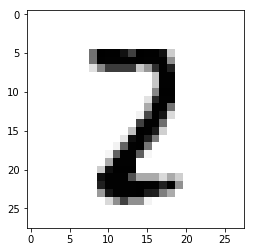

In [32]:
img = X_train[10];
plt.imshow(img.reshape(28,28), cmap=matplotlib.cm.binary);
#plt.axis('off')

In [47]:
img_shifted = shift(img.reshape(28,28), [0,10]);
shift(img.reshape(28,28), [1,0]).reshape(img.shape[0]).shape

(784,)

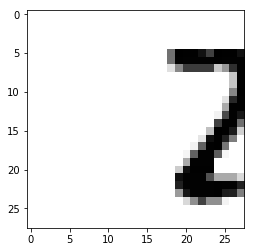

In [36]:
plt.imshow(img_shifted, cmap=matplotlib.cm.binary);

In [83]:
X_train_augmented = X_train.copy();
y_train_augmented = y_train.copy();
for idx, img in enumerate(X_train,0):
    img_shifted_down  = shift(img.reshape(28,28), [1,0]) .reshape(img.shape[0]);
    img_shifted_up    = shift(img.reshape(28,28), [-1,0]).reshape(img.shape[0]);
    img_shifted_right = shift(img.reshape(28,28), [0,1]) .reshape(img.shape[0]);
    img_shifted_left  = shift(img.reshape(28,28), [0,-1]).reshape(img.shape[0]);
    X_train_augmented = np.append(X_train_augmented, [img_shifted_down,img_shifted_up,
                                  img_shifted_right, img_shifted_left], axis=0);
    for k in range(4):
        y_train_augmented = np.append(y_train_augmented, y_train[idx]);
    if (idx%1000==0):
        print(idx);

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000


In [94]:
import pickle
data_augmented = {"data": X_train_augmented, "target": y_train_augmented};
type(data_augmented)
f = open("MNIST_augmented","wb");
pickle.dump(data_augmented, f);
f.close();
del f;

In [96]:
f = open('MNIST_augmented', 'rb');
temp = pickle.load(f);
f.close();
X_train_augmented = temp["data"];
y_train_augmented = temp["target"];
del f, temp;

In [101]:
knn_unscaled_augmented = KNeighborsClassifier(weights='distance', n_neighbors=4);
knn_unscaled_augmented.fit(X_train_augmented,y_train_augmented);
print("--------");
y_pred_test_unscaled_augmented = knn_unscaled_augmented.predict(X_test);
print("--------");
accuracy_score(y_test, y_pred_test_unscaled_augmented)


--------
--------


0.9763

## By shifting the image of 1 pixel we increased accuracy by 0.5 (actually the book shifted each of 5 pix).